# Review of line fitting

In [1]:
import jax
import jax.numpy as jnp
import tqdm
import blackjax

rng_key = jax.random.PRNGKey(0)

d = 20

C = jax.random.normal(rng_key, (d, d)) * 0.1 # draws a random dxd matrix of number from a normal dist., scaled by 0.1
like_cov = C @ C.T # makes the covariance matrix positive definite, covariances of variables
like_mean = jax.random.normal(rng_key, (d,)) # draws a random d-dimensional mean vector from a normal distribution, expected value of each variable

prior_mean = jnp.zeros(d) # prior mean vector of zeros
prior_cov = jnp.eye(d) * 1 # prior covariance matrix as identity matrix scaled by 1

In [20]:
logprior_density = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, prior_mean, prior_cov
)

loglikelihood_function = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, like_mean, like_cov
) # calculates the log-likelihood of x given the likelihood mean and covariance

# def loglikelihood_function(x):
#     return jax.scipy.stats.multivariate_normal.logpdf(x, like_mean, like_cov)

rng_key, prior_sample_key = jax.random.split(rng_key)
n_live = 1000
initial_population = jax.random.multivariate_normal(
    prior_sample_key, prior_mean, prior_cov, (n_live,)
)

In [ ]:
# logprior_density is a SINGLE python function that returns the joint log-density of the prior

In [ ]:
num_inner_steps = 3 * d
num_delete = int(n_live*0.1)

algo = blackjax.nss(
    logprior_fn=logprior_density,
    loglikelihood_fn=loglikelihood_function,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
)

state = algo.init(initial_population)

In [ ]:
from blackjax.ns.base import NSState
from blackjax.ns.base import NSInfo


In [ ]:
@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

In [ ]:
dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.logZ_live - state.logZ < -3:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(num_delete)

In [ ]:
from blackjax.ns.utils import log_weights, finalise, sample, ess

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead)
log_w = log_weights(weight_key, final_state, shape=100)
samples = sample(sample_key, final_state, shape = n_live)
ns_ess = ess(sample_key, final_state)

logzs = jax.scipy.special.logsumexp(log_w, axis=0)

In [ ]:
from jax.scipy.linalg import solve_triangular, cho_solve

def compute_logZ(mu_L, Sigma_L, logLmax=0, mu_pi=None, Sigma_pi=None):
    """
    Compute log evidence, posterior covariance, and posterior mean.
    
    Args:
        mu_L: Likelihood mean
        Sigma_L: Likelihood covariance
        logLmax: Maximum log likelihood value
        mu_pi: Prior mean
        Sigma_pi: Prior covariance
    
    Returns:
        Tuple of (log evidence, posterior covariance, posterior mean)
    """
    # Use Cholesky decomposition for more stable calculations
    L_pi = jnp.linalg.cholesky(Sigma_pi)
    L_L = jnp.linalg.cholesky(Sigma_L)
    
    # Compute precision matrices (inverse covariances)
    prec_pi = cho_solve((L_pi, True), jnp.eye(L_pi.shape[0]))
    prec_L = cho_solve((L_L, True), jnp.eye(L_L.shape[0]))
    
    # Compute posterior precision and its Cholesky factor
    prec_P = prec_pi + prec_L
    L_P = jnp.linalg.cholesky(prec_P)
    
    # Compute Sigma_P using Cholesky factor
    Sigma_P = cho_solve((L_P, True), jnp.eye(L_P.shape[0]))
    
    # Compute mu_P more stably
    b = cho_solve((L_pi, True), mu_pi) + cho_solve((L_L, True), mu_L)
    mu_P = cho_solve((L_P, True), b)
    
    # Compute log determinants using Cholesky factors
    logdet_Sigma_P = -2 * jnp.sum(jnp.log(jnp.diag(L_P)))
    logdet_Sigma_pi = 2 * jnp.sum(jnp.log(jnp.diag(L_pi)))
    
    # Compute quadratic forms using Cholesky factors
    diff_pi = mu_P - mu_pi
    diff_L = mu_P - mu_L
    quad_pi = jnp.sum(jnp.square(solve_triangular(L_pi, diff_pi, lower=True)))
    quad_L = jnp.sum(jnp.square(solve_triangular(L_L, diff_L, lower=True)))
    
    return (
        (
            logLmax
            + logdet_Sigma_P / 2
            - logdet_Sigma_pi / 2
            - quad_pi / 2
            - quad_L / 2
        ),
        Sigma_P,
        mu_P,
    )

log_analytic_evidence, post_cov, post_mean = compute_logZ(
    like_mean,
    like_cov,
    mu_pi=prior_mean,
    Sigma_pi=prior_cov,
    logLmax=loglikelihood_function(like_mean),
)

print(f"ESS: {int(ns_ess)}")
print(f"logZ estimate: {logzs.mean():.2f} +- {logzs.std():.2f}")
print(f"analytic logZ: {log_analytic_evidence:.2f}")

In [ ]:
import matplotlib.pyplot as plt

posterior_truth = jax.random.multivariate_normal(
    rng_key, post_mean, post_cov, (n_live,)
)

plt.scatter(
    initial_population[..., 0], initial_population[..., 1], label="prior"
)
plt.scatter(
    posterior_truth[..., 0], posterior_truth[..., 1], label="posterior"
)
plt.scatter(
    samples[..., 0], samples[..., 1], label="nested sampling posterior"
)
plt.legend()

# Bimodal Posterior

Python(33587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Dead points: 0 dead points [00:00, ? dead points/s]

iteration: 0  logZ_live: -4.7499189376831055  logZ: -inf


Dead points: 500 dead points [00:04, 102.71 dead points/s]

iteration: 1  logZ_live: -4.740111351013184  logZ: -21.458349227905273
iteration: 2  logZ_live: -4.755232334136963  logZ: -17.9868106842041
iteration: 3  logZ_live: -4.76273775100708  logZ: -16.37697982788086
iteration: 4  logZ_live: -4.786632061004639  logZ: -15.19480037689209


Dead points: 2500 dead points [00:04, 668.23 dead points/s]

iteration: 5  logZ_live: -4.795008182525635  logZ: -14.158952713012695
iteration: 6  logZ_live: -4.777637481689453  logZ: -13.226568222045898
iteration: 7  logZ_live: -4.7890729904174805  logZ: -12.37690258026123
iteration: 8  logZ_live: -4.796444892883301  logZ: -11.625618934631348
iteration: 9  logZ_live: -4.780381202697754  logZ: -10.964822769165039
iteration: 10  logZ_live: -4.784628391265869  logZ: -10.359435081481934
iteration: 11  logZ_live: -4.794000148773193  logZ: -9.824258804321289


Dead points: 6000 dead points [00:05, 1993.56 dead points/s]

iteration: 12  logZ_live: -4.779991149902344  logZ: -9.347756385803223
iteration: 13  logZ_live: -4.783369064331055  logZ: -8.916370391845703
iteration: 14  logZ_live: -4.795198917388916  logZ: -8.530417442321777
iteration: 15  logZ_live: -4.804528713226318  logZ: -8.175535202026367
iteration: 16  logZ_live: -4.812653064727783  logZ: -7.859277725219727
iteration: 17  logZ_live: -4.835933685302734  logZ: -7.572484970092773


Dead points: 9000 dead points [00:05, 3445.26 dead points/s]

iteration: 18  logZ_live: -4.851960182189941  logZ: -7.309478759765625
iteration: 19  logZ_live: -4.871011257171631  logZ: -7.073231220245361
iteration: 20  logZ_live: -4.897591590881348  logZ: -6.856679916381836
iteration: 21  logZ_live: -4.930749416351318  logZ: -6.658507823944092
iteration: 22  logZ_live: -4.963541030883789  logZ: -6.478873252868652
iteration: 23  logZ_live: -5.002356052398682  logZ: -6.316235065460205


Dead points: 12000 dead points [00:05, 5245.62 dead points/s]

iteration: 24  logZ_live: -5.045123100280762  logZ: -6.168266296386719
iteration: 25  logZ_live: -5.095865249633789  logZ: -6.034577369689941
iteration: 26  logZ_live: -5.147963523864746  logZ: -5.913050174713135
iteration: 27  logZ_live: -5.200920581817627  logZ: -5.802326679229736
iteration: 28  logZ_live: -5.260506629943848  logZ: -5.701901435852051
iteration: 29  logZ_live: -5.322464942932129  logZ: -5.611003875732422


Dead points: 15000 dead points [00:05, 7388.30 dead points/s]

iteration: 30  logZ_live: -5.389862060546875  logZ: -5.528905868530273
iteration: 31  logZ_live: -5.457292079925537  logZ: -5.454526424407959
iteration: 32  logZ_live: -5.530078887939453  logZ: -5.387144088745117
iteration: 33  logZ_live: -5.605060577392578  logZ: -5.326167583465576
iteration: 34  logZ_live: -5.682879447937012  logZ: -5.271008014678955
iteration: 35  logZ_live: -5.763369083404541  logZ: -5.221132755279541


Dead points: 18000 dead points [00:05, 9496.02 dead points/s]

iteration: 36  logZ_live: -5.846948623657227  logZ: -5.176023006439209
iteration: 37  logZ_live: -5.932070732116699  logZ: -5.1352739334106445
iteration: 38  logZ_live: -6.01839542388916  logZ: -5.098409175872803
iteration: 39  logZ_live: -6.107189178466797  logZ: -5.065123081207275
iteration: 40  logZ_live: -6.197222709655762  logZ: -5.035110950469971


Dead points: 20500 dead points [00:05, 10757.88 dead points/s]

iteration: 41  logZ_live: -6.287942886352539  logZ: -5.008062839508057
iteration: 42  logZ_live: -6.381020545959473  logZ: -4.98369026184082
iteration: 43  logZ_live: -6.475042343139648  logZ: -4.961724281311035
iteration: 44  logZ_live: -6.570199012756348  logZ: -4.941938400268555
iteration: 45  logZ_live: -6.665770530700684  logZ: -4.924119472503662
iteration: 46  logZ_live: -6.762716293334961  logZ: -4.908071994781494


Dead points: 23500 dead points [00:05, 13399.64 dead points/s]

iteration: 47  logZ_live: -6.860151290893555  logZ: -4.893613338470459
iteration: 48  logZ_live: -6.958246231079102  logZ: -4.880585193634033
iteration: 49  logZ_live: -7.057314872741699  logZ: -4.868836402893066
iteration: 50  logZ_live: -7.1570940017700195  logZ: -4.858251571655273
iteration: 51  logZ_live: -7.257267951965332  logZ: -4.848719120025635


Dead points: 26000 dead points [00:05, 14819.92 dead points/s]

iteration: 52  logZ_live: -7.3580217361450195  logZ: -4.840134143829346
iteration: 53  logZ_live: -7.459261894226074  logZ: -4.832401752471924
iteration: 54  logZ_live: -7.560820579528809  logZ: -4.825439929962158
iteration: 55  logZ_live: -7.662541389465332  logZ: -4.8191704750061035
iteration: 56  logZ_live: -7.764889717102051  logZ: -4.813523292541504


Dead points: 28500 dead points [00:06, 15150.48 dead points/s]

iteration: 57  logZ_live: -7.867518424987793  logZ: -4.808439254760742
iteration: 58  logZ_live: -7.97037410736084  logZ: -4.803861141204834
iteration: 59  logZ_live: -8.073580741882324  logZ: -4.799739837646484
iteration: 60  logZ_live: -8.176885604858398  logZ: -4.796029567718506
iteration: 61  logZ_live: -8.280467987060547  logZ: -4.792689323425293


Dead points: 31000 dead points [00:06, 16057.52 dead points/s]

iteration: 62  logZ_live: -8.384151458740234  logZ: -4.789682865142822
iteration: 63  logZ_live: -8.487974166870117  logZ: -4.786975860595703
iteration: 64  logZ_live: -8.59207534790039  logZ: -4.784539222717285
iteration: 65  logZ_live: -8.696216583251953  logZ: -4.782345294952393
iteration: 66  logZ_live: -8.80044937133789  logZ: -4.780370712280273


Dead points: 33500 dead points [00:06, 16863.20 dead points/s]

iteration: 67  logZ_live: -8.90485954284668  logZ: -4.778593063354492
iteration: 68  logZ_live: -9.009344100952148  logZ: -4.7769927978515625
iteration: 69  logZ_live: -9.113943099975586  logZ: -4.775552272796631
iteration: 70  logZ_live: -9.218611717224121  logZ: -4.774255752563477


Dead points: 35500 dead points [00:06, 16114.59 dead points/s]

iteration: 71  logZ_live: -9.323363304138184  logZ: -4.7730889320373535
iteration: 72  logZ_live: -9.428144454956055  logZ: -4.77203893661499
iteration: 73  logZ_live: -9.532971382141113  logZ: -4.771093845367432
iteration: 74  logZ_live: -9.637858390808105  logZ: -4.770243167877197


Dead points: 37500 dead points [00:06, 16147.87 dead points/s]

iteration: 75  logZ_live: -9.742785453796387  logZ: -4.769477367401123


Dead points: 38000 dead points [00:06, 5661.84 dead points/s] 


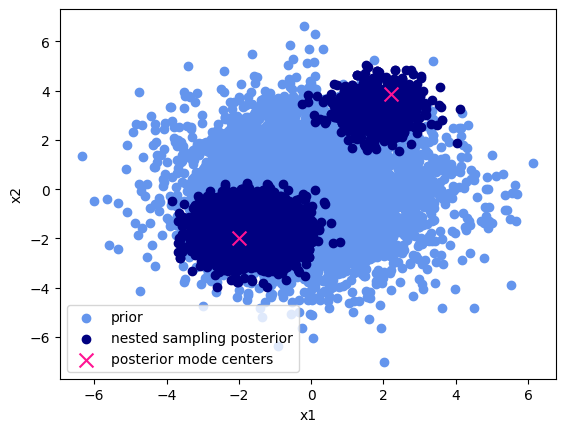

In [2]:
import jax
import jax.numpy as jnp
import tqdm
import blackjax

# DEFINE PRIOR & LIKELIHOOD

rng_key = jax.random.PRNGKey(0)

d = 2

# C = jax.random.normal(rng_key, (d, d)) * 0.5 # draws a random dxd matrix of number from a normal dist., scaled by 0.1
# like_cov = C @ C.T # makes the covariance matrix positive definite, covariances of variables
like_cov_scale = 0.5  # Adjust this value to change the mode width
like_cov = jnp.eye(d) * like_cov_scale

like_mean_1 = jax.random.normal(rng_key, (d,)) + 3
like_mean_2 = jnp.ones(d) -3

loglikelihood_fn_1 = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, like_mean_1, like_cov
)

loglikelihood_fn_2 = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, like_mean_2, like_cov
)

def loglikelihood_function_mm(x):
    log_L_1 = loglikelihood_fn_1(x)
    log_L_2 = loglikelihood_fn_2(x)
    return jnp.log(0.5) + jax.scipy.special.logsumexp(jnp.array([log_L_1, log_L_2]))

loglikelihood_function = loglikelihood_function_mm

prior_mean = jnp.zeros(d) # prior mean vector of zeros
prior_cov = jnp.eye(d) * 3 # prior covariance matrix as identity matrix scaled by 1

logprior_density = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
x, prior_mean, prior_cov
)

# SAMPLE INITIAL POPULATION FROM PRIOR
rng_key, prior_sample_key = jax.random.split(rng_key)
n_live = 5000
initial_population = jax.random.multivariate_normal(
prior_sample_key, prior_mean, prior_cov, (n_live,)
)

# NESTED SAMPLING RUN
num_inner_steps = 3 * d
num_delete = int(n_live*0.1)

algo = blackjax.nss(
    logprior_fn=logprior_density,
    loglikelihood_fn=loglikelihood_function,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
    )

state = algo.init(initial_population)

# NESTED SAMPLING LOOP
from blackjax.ns.base import NSState
from blackjax.ns.base import NSInfo

@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

iteration_count = 0
live_points_snapshots = []
dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    live_points_snapshots.append(jnp.array(state.particles[..., :2]))
    
    while not state.logZ_live - state.logZ < -5:
        print('iteration:', iteration_count,
                  ' logZ_live:', float(state.logZ_live),
                  ' logZ:', float(state.logZ),
                  flush=True)
        iteration_count += 1
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(num_delete)

        live_points_snapshots.append(jnp.array(state.particles[..., :2]))

live_points_snapshots.append(jnp.array(state.particles[..., :2]))

# POST-PROCESSING
from blackjax.ns.utils import log_weights, finalise, sample, ess

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead)
log_w = log_weights(weight_key, final_state, shape=100)
samples = sample(sample_key, final_state, shape = n_live)
ns_ess = ess(sample_key, final_state)
logzs = jax.scipy.special.logsumexp(log_w, axis=0)

# PLOTTING
import matplotlib.pyplot as plt

plt.scatter(
initial_population[..., 0], initial_population[..., 1], label="prior", c='cornflowerblue'
)

plt.scatter(
samples[..., 0], samples[..., 1], label="nested sampling posterior", c='navy'
)

# Mode centers

plt.scatter(
like_mean_1[0], like_mean_1[1], marker='x', color='deeppink', s=100, label='posterior mode centers'
)

plt.scatter(
like_mean_2[0], like_mean_2[1], marker='x', color='deeppink', s=100,
)

# set equal axis ratio
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend() 

In [15]:
import imageio

gif_filename = 'live_points_snapshots.gif'

frames = []

for snapshot in live_points_snapshots:
    plt.figure(figsize=(7,7))
    plt.scatter(snapshot[..., 0], snapshot[..., 1], alpha=0.5, c='cornflowerblue')
    plt.scatter(
    like_mean_1[0], like_mean_1[1], marker='x', color='deeppink', s=100, label='posterior mode centers'
    )

    plt.scatter(
    like_mean_2[0], like_mean_2[1], marker='x', color='deeppink', s=100,
    )

    plt.title('Live Points Snapshot')
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    
    plt.savefig('temp_frame.png')
    plt.close()  # Close figure

    frames.append(imageio.imread('temp_frame.png'))

# MKAKE GIF
imageio.mimsave(gif_filename, frames, duration=0.5)

/var/folders/l8/g2bx224n7q35swctm351kzqc0000gn/T/ipykernel_4878/3956166576.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread('temp_frame.png'))


GIF saved as live_points_snapshots.gif


In [ ]:
# TO_CSV AND THEN LOOK AT ANESTHETIC

In [ ]:
# MAKE MORE VISUALLY APPEALING AGAIN!!